#importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install sklego to apply easily GMM model
!pip install sklego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 3.9 MB/s eta 0:00:00


In [3]:
# omit warnings
# import warnings
# warnings.filterwarnings("ignore")

# to show multiple results inside a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [4]:

# Import required Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import copy

# Classifier Libraries
from sklearn.ensemble import IsolationForest
from sklego.mixture import GMMClassifier, GMMOutlierDetector
import collections


# train/test split libraries and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# libraries to handle imbalanced datasets

from imblearn.under_sampling import NearMiss

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, \
accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score, average_precision_score
from collections import Counter
import numpy as np

# **Feature Engineering**

In [5]:
# Load your data here before using df
df = pd.read_excel('/content/drive/MyDrive/infosys/project/NEAR_token_transaction_data.xlsx')

In [6]:
df.head()

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0


In [7]:
df.describe()

,Blockno,UnixTimestamp,DateTime (UTC),Quantity
count,1.983600e+04,1.983600e+04,19836,19836.000000
mean,1.968441e+07,1.713463e+09,2024-04-18 17:49:02.953417984,377.944387
min,1.890902e+07,1.704069e+09,2024-01-01 00:25:35,0.000000
25%,1.946597e+07,1.710817e+09,2024-03-19 02:58:35,3.213580
50%,1.973666e+07,1.714100e+09,2024-04-26 02:48:23,72.444861
75%,1.993754e+07,1.716527e+09,2024-05-24 05:06:35,293.678666
max,2.017186e+07,1.719357e+09,2024-06-25 23:04:35,750000.000000
std,3.220605e+05,3.898956e+06,NaN,8007.345063


In [8]:
df.columns

Index(['Transaction Hash', 'Blockno', 'UnixTimestamp', 'DateTime (UTC)',
       'From', 'To', 'Quantity', 'Method'],
      dtype='object')

In [9]:
df.shape

(19836, 8)

In [10]:
df.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0


In [11]:
# Create a copy of the DataFrame to work on
data = df.copy()

# Convert 'DateTime (UTC)' to datetime format
data['DateTime (UTC)'] = pd.to_datetime(data['DateTime (UTC)'])

# Extract timestamp features
data['Year'] = data['DateTime (UTC)'].dt.year
data['Month'] = data['DateTime (UTC)'].dt.month
data['Day'] = data['DateTime (UTC)'].dt.day
data['Hour'] = data['DateTime (UTC)'].dt.hour
data['Minute'] = data['DateTime (UTC)'].dt.minute
data['Day_Of_Week'] = data['DateTime (UTC)'].dt.dayofweek

# Sort by DateTime to calculate time intervals
data = data.sort_values(by='DateTime (UTC)')
data['Time_Diff'] = data['DateTime (UTC)'].diff().dt.total_seconds()

# Display the resulting DataFrame with timestamp features
print("Timestamp Features:")
data[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Day_Of_Week', 'Time_Diff']].head()

Timestamp Features:


,Year,Month,Day,Hour,Minute,Day_Of_Week,Time_Diff
0,2024,1,1,0,25,0,NaN
1,2024,1,1,0,36,0,636.0
2,2024,1,1,0,36,0,0.0
3,2024,1,1,0,36,0,0.0
4,2024,1,1,0,51,0,948.0


In [12]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [13]:
data['Time_Diff'] = data['DateTime (UTC)'].diff().dt.total_seconds().fillna(0)

In [14]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [15]:
# Apply log transformation for Quantity
import numpy as np
data['Quantity_Log'] = np.log1p(data['Quantity'])

# Bin the Quantity column
bins = [0, 100, 500, 1000, 5000, np.inf]
labels = ['0-100', '101-500', '501-1000', '1001-5000', '5000+']
data['Quantity_Binned'] = pd.cut(data['Quantity'], bins=bins, labels=labels)

# Display transformed columns
data[['Quantity', 'Quantity_Log', 'Quantity_Binned']].head()


,Quantity,Quantity_Log,Quantity_Binned
0,36.593837,3.626840,0-100
1,104.984275,4.663291,101-500
2,0.079035,0.076067,0-100
3,104.984275,4.663291,101-500
4,10.247435,2.420140,0-100


In [16]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [17]:
# Fill NaN values in 'Quantity_Binned' with '0-100'
data['Quantity_Binned'] = data['Quantity_Binned'].fillna('0-100')

In [18]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [19]:
# Address Analysis
unique_from_addresses = data['From'].nunique()
unique_to_addresses = data['To'].nunique()
frequent_from_addresses = data['From'].value_counts().head(10)
frequent_to_addresses = data['To'].value_counts().head(10)

# Display address analysis results
print("\nUnique 'From' Addresses:", unique_from_addresses)
print("Unique 'To' Addresses:", unique_to_addresses)
print("\nTop 10 Frequent 'From' Addresses:\n", frequent_from_addresses)
print("\nTop 10 Frequent 'To' Addresses:\n", frequent_to_addresses)


Unique 'From' Addresses: 1823
Unique 'To' Addresses: 3273

Top 10 Frequent 'From' Addresses:
 From
0x983dfba1c0724786598af0e63a9a6f94aabd24a1    3575
0x6469b34a2a4723163c4902dbbdea728d20693c12    2425
0xe37e799d5077682fa0a244d46e5649f71457bd09    1706
0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea    1679
0x22f9dcf4647084d6c31b2765f6910cd85c178c18    1656
0x74de5d4fcbf63e00296fd95d33236b9794016631    1244
0x1111111254eeb25477b68fb85ed929f73a960582    1147
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad     546
0x6889de313803839ce3e15996a86167f639b4a634     401
0x6b75d8af000000e20b7a7ddf000ba900b4009a80     377
Name: count, dtype: int64

Top 10 Frequent 'To' Addresses:
 To
0x6469b34a2a4723163c4902dbbdea728d20693c12    1996
0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0    1787
0x983dfba1c0724786598af0e63a9a6f94aabd24a1    1435
0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea    1379
0x1111111254eeb25477b68fb85ed929f73a960582    1320
0x74de5d4fcbf63e00296fd95d33236b9794016631    1244
0x22f9dcf4647084d6c31

In [20]:
# Identify self-trades
data['Is_Self_Trade'] = data['From'] == data['To']

# Count the number of self-trades
num_self_trades = data['Is_Self_Trade'].sum()

# Display self-trade results
print("Number of Self-Trades:", num_self_trades)
print("\nExample Self-Trades:")
data[data['Is_Self_Trade']].head()


Number of Self-Trades: 39

Example Self-Trades:


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Year,Month,Day,Hour,Minute,Day_Of_Week,Time_Diff,Quantity_Log,Quantity_Binned,Is_Self_Trade
96,0x688602a2eb4ad892a53b6fbd101fb2e8626cff8c852a...,18916285,1704157055,2024-01-02 00:57:35,0xb54b9f559d57b140befbfa47ba43c472ebfcac56,0xb54b9f559d57b140befbfa47ba43c472ebfcac56,2.000000,Transfer,2024,1,2,0,57,1,312.0,1.098612,0-100,True
1379,0x134dded289c7a6368c76d3a5b50dddb2dbca58e8a1ce...,19092755,1706296019,2024-01-26 19:06:59,0xf3e1c9b2ef3736413b834a2038db1337f4fa5f23,0xf3e1c9b2ef3736413b834a2038db1337f4fa5f23,118.280799,Transfer,2024,1,26,19,6,4,4776.0,4.781480,101-500,True
1380,0x98888e0ddd0012d95debbc9b9f7c0598d41903a0d923...,19092761,1706296103,2024-01-26 19:08:23,0xf3e1c9b2ef3736413b834a2038db1337f4fa5f23,0xf3e1c9b2ef3736413b834a2038db1337f4fa5f23,118.280799,Transfer,2024,1,26,19,8,4,84.0,4.781480,101-500,True
1414,0x99a725db92489f24ab5079245f9de0da3df83a7ecb55...,19101031,1706396327,2024-01-27 22:58:47,0xf8178e3e5b4acd46eaf5e25cfd458a5ee3c98f81,0xf8178e3e5b4acd46eaf5e25cfd458a5ee3c98f81,1.527081,Transfer,2024,1,27,22,58,5,2688.0,0.927065,0-100,True
1626,0xfb9cb3ad7064f57585a35653292dfd50e6ed20fa6a78...,19138528,1706850371,2024-02-02 05:06:11,0x30b128c32a765040a5be6292067c277dd0492657,0x30b128c32a765040a5be6292067c277dd0492657,7.416583,Transfer,2024,2,2,5,6,4,72.0,2.130204,0-100,True


In [21]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [22]:
# Initialize a new column to mark circular trades
data['Is_Circular_Trade'] = False

# Group by 'From' and 'To' pairs
grouped_pairs = data.groupby(['From', 'To'])

# Identify pairs with multiple transactions
for (from_addr, to_addr), group in grouped_pairs:
    if len(group) > 1:  # If more than one transaction exists for the pair
        data.loc[group.index, 'Is_Circular_Trade'] = True

# Count the number of circular trades
num_circular_trades = data['Is_Circular_Trade'].sum()

# Display circular trade results
print("Number of Circular Trades:", num_circular_trades)
print("\nExample Circular Trades:")
data[data['Is_Circular_Trade']].head()

Number of Circular Trades: 15513

Example Circular Trades:


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Year,Month,Day,Hour,Minute,Day_Of_Week,Time_Diff,Quantity_Log,Quantity_Binned,Is_Self_Trade,Is_Circular_Trade
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,2024,1,1,0,25,0,0.0,3.626840,0-100,False,True
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,2024,1,1,0,36,0,636.0,4.663291,101-500,False,True
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,2024,1,1,0,36,0,0.0,0.076067,0-100,False,True
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,2024,1,1,0,51,0,948.0,2.420140,0-100,False,True
5,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.007715,0x415565b0,2024,1,1,0,51,0,0.0,0.007685,0-100,False,True


In [23]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [24]:
# One-Hot Encoding for the 'Method' column
if 'Method' in data.columns:
    data_one_hot = pd.get_dummies(data, columns=['Method'], prefix='Method')

print("One-Hot Encoded Columns:")
print(data_one_hot.filter(like='Method').head())

One-Hot Encoded Columns:
   Method_-  Method_0x00000000  Method_0x415565b0  \
0     False              False              False   
1     False              False               True   
2     False              False               True   
3     False              False               True   
4     False              False               True   

   Method_Across Swap And Bridge  Method_Add Liquidity ETH  Method_Aggregate  \
0                          False                     False             False   
1                          False                     False             False   
2                          False                     False             False   
3                          False                     False             False   
4                          False                     False             False   

   Method_Arbitrary Calls With Eth Check  Method_Batch Withdraw All ERC20  \
0                                  False                            False   
1                    

In [25]:
data.head()

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Year,Month,Day,Hour,Minute,Day_Of_Week,Time_Diff,Quantity_Log,Quantity_Binned,Is_Self_Trade,Is_Circular_Trade
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,2024,1,1,0,25,0,0.0,3.626840,0-100,False,True
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,2024,1,1,0,36,0,636.0,4.663291,101-500,False,True
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,2024,1,1,0,36,0,0.0,0.076067,0-100,False,True
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0,2024,1,1,0,36,0,0.0,4.663291,101-500,False,False
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,2024,1,1,0,51,0,948.0,2.420140,0-100,False,True


In [26]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for the 'Method' column
if 'Method' in data.columns:
    label_encoder = LabelEncoder()
    data['Method_Label'] = label_encoder.fit_transform(data['Method'])

In [27]:
print("\nLabel Encoded 'Method':")
data[['Method', 'Method_Label']].head()


Label Encoded 'Method':


,Method,Method_Label
0,Sell To Uniswap,51
1,0x415565b0,2
2,0x415565b0,2
3,0x415565b0,2
4,0x415565b0,2


In [28]:
data['Method'].isnull().sum()

0

In [29]:
# Ensure the DataFrame is sorted by 'DateTime (UTC)' for proper rolling calculations
data = data.sort_values(by='DateTime (UTC)')

# Define the rolling window size (e.g., 5 transactions)
window_size = 5

# Calculate rolling mean and standard deviation for 'Quantity'
data['Rolling_Mean_Quantity'] = data['Quantity'].rolling(window=window_size).mean()
data['Rolling_Std_Quantity'] = data['Quantity'].rolling(window=window_size).std()

# Display the rolling statistics
print("Rolling Statistics (Mean and Std):")
data[['Quantity', 'Rolling_Mean_Quantity', 'Rolling_Std_Quantity']].head(window_size + 5)


Rolling Statistics (Mean and Std):


,Quantity,Rolling_Mean_Quantity,Rolling_Std_Quantity
0,36.593837,NaN,NaN
1,104.984275,NaN,NaN
2,0.079035,NaN,NaN
3,104.984275,NaN,NaN
4,10.247435,51.377771,50.717709
5,0.007715,44.060547,55.771304
6,10.247435,25.113179,44.939864
7,166.773563,58.452085,74.097753
8,166.773563,70.809942,87.702085
9,26.809383,74.122332,85.117559


In [30]:
data.dtypes

,0
Transaction Hash,object
Blockno,int64
UnixTimestamp,int64
DateTime (UTC),datetime64[ns]
From,object
To,object
Quantity,float64
Method,object
Year,int32
Month,int32


In [31]:
# Fill NaN values in 'Rolling_Mean_Quantity' with the mean of the column
data['Rolling_Mean_Quantity'] = data['Rolling_Mean_Quantity'].fillna(data['Rolling_Mean_Quantity'].mean())

# Fill NaN values in 'Rolling_Std_Quantity' with the mean of the column
data['Rolling_Std_Quantity'] = data['Rolling_Std_Quantity'].fillna(data['Rolling_Std_Quantity'].mean())


In [32]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [33]:
# Calculate the IQR for Quantity
Q1 = data['Quantity'].quantile(0.25)  # First quartile (25th percentile)
Q3 = data['Quantity'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
data['Is_Outlier'] = (data['Quantity'] < lower_bound) | (data['Quantity'] > upper_bound)

# Cap outliers at the bounds
data['Quantity_Capped'] = data['Quantity'].clip(lower=lower_bound, upper=upper_bound)

# Display the results
print("Outlier Detection and Capping:")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
print(f"Number of Outliers Detected: {data['Is_Outlier'].sum()}")
print("\nSample Data with Capped Quantity:")
data[['Quantity', 'Is_Outlier', 'Quantity_Capped']].head(10)

Outlier Detection and Capping:
Lower Bound: -432.4840479331298, Upper Bound: 729.3762937082222
Number of Outliers Detected: 1689

Sample Data with Capped Quantity:


,Quantity,Is_Outlier,Quantity_Capped
0,36.593837,False,36.593837
1,104.984275,False,104.984275
2,0.079035,False,0.079035
3,104.984275,False,104.984275
4,10.247435,False,10.247435
5,0.007715,False,0.007715
6,10.247435,False,10.247435
7,166.773563,False,166.773563
8,166.773563,False,166.773563
9,26.809383,False,26.809383


In [34]:
# Unusual Trades Based on Frequency (Very High Activity)
transaction_counts = data.groupby('From').size().reset_index(name='Transaction_Count')
high_activity_threshold = transaction_counts['Transaction_Count'].quantile(0.95)  # Top 5% active addresses
high_activity_addresses = transaction_counts[transaction_counts['Transaction_Count'] > high_activity_threshold]['From']

# Create the 'Is_High_Activity' column
data['Is_High_Activity'] = data['From'].isin(high_activity_addresses) # Check if 'From' address is in high_activity_addresses

print("\nUnusual Trades Based on High Activity:")
data[data['Is_High_Activity']].head()


Unusual Trades Based on High Activity:


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Year,Month,...,Quantity_Log,Quantity_Binned,Is_Self_Trade,Is_Circular_Trade,Method_Label,Rolling_Mean_Quantity,Rolling_Std_Quantity,Is_Outlier,Quantity_Capped,Is_High_Activity
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,2024,1,...,3.626840,0-100,False,True,51,377.950022,458.861900,False,36.593837,True
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,2024,1,...,4.663291,101-500,False,True,2,377.950022,458.861900,False,104.984275,True
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,2024,1,...,0.076067,0-100,False,True,2,377.950022,458.861900,False,0.079035,True
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0,2024,1,...,4.663291,101-500,False,False,2,377.950022,458.861900,False,104.984275,True
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,2024,1,...,2.420140,0-100,False,True,2,51.377771,50.717709,False,10.247435,True


In [35]:
###  Frequency Analysis for 'From' Addresses ###
# Count the frequency of transactions by 'From' addresses
from_address_frequency = data['From'].value_counts().reset_index()
from_address_frequency.columns = ['From', 'Transaction_Frequency']

# Merge the frequency back into the dataset
data = data.merge(from_address_frequency, on='From', how='left')

print("Frequency Analysis for 'From' Addresses:")
data[['From', 'Transaction_Frequency']].head()

Frequency Analysis for 'From' Addresses:


,From,Transaction_Frequency
0,0x6469b34a2a4723163c4902dbbdea728d20693c12,2425
1,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,3575
2,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,3575
3,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,1656
4,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,3575


In [36]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns to scale (update as needed)
numerical_columns = ['Quantity', 'Time_Diff']  # Replace with actual column names in your dataset

# Ensure the columns are numeric
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values in the numerical columns (e.g., fill with 0 or any other strategy)
data[numerical_columns] = data[numerical_columns].fillna(0)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the selected columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display the scaled columns
print("Scaled Numerical Features using Min-Max Scaling:")
print(data[numerical_columns].head())


Scaled Numerical Features using Min-Max Scaling:
       Quantity  Time_Diff
0  4.879178e-05   0.000000
1  1.399790e-04   0.012067
2  1.053794e-07   0.000000
3  1.399790e-04   0.000000
4  1.366325e-05   0.017987


In [37]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale (update as needed)
numerical_columns = ['Quantity', 'Time_Diff']

# Ensure the columns are numeric
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values in the numerical columns (e.g., fill with 0 or any other strategy)
data[numerical_columns] = data[numerical_columns].fillna(0)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply Standard Scaling to the selected columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display the scaled columns
print("Scaled Numerical Features using Standard Scaling:")
print(data[numerical_columns].head())


Scaled Numerical Features using Standard Scaling:
   Quantity  Time_Diff
0 -0.042631  -0.375723
1 -0.034090  -0.065674
2 -0.047191  -0.375723
3 -0.034090  -0.375723
4 -0.045921   0.086425


#visualization using graphs



Number of Nodes: 3516
Number of Edges: 5434


<Figure size 1200x800 with 0 Axes>

{('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x776a0725094cbf984e31b43d17e8aaec3c88294a'): Text(0.2663956192475221, 0.7024722767918754, '-0.04563717519714064'),
 ('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x7cdf2157738398e0f29b3f1b689846b347f92c6b'): Text(-0.1837233794005927, 0.10045055704359895, '-0.04385271919475269'),
 ('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x983dfba1c0724786598af0e63a9a6f94aabd24a1'): Text(-0.5092170474804152, 0.2011440246193812, '-0.03612102067751487'),
 ('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x604c1dd9a7369d2ad30d59df269177bc313c112c'): Text(-0.5151701203091644, 0.8089797752213637, '-0.046701146230503233'),
 ('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x74de5d4fcbf63e00296fd95d33236b9794016631'): Text(0.2941700943586638, 0.3656994510491298, '-0.04712650625922948'),
 ('0x6469b34a2a4723163c4902dbbdea728d20693c12',
  '0x1c742eed25fdd98588de2263b0914565fb4d7d04'): Text(-0.2551799583488592, 0.04738239173286152, '-0.034686730723

Text(0.5, 1.0, 'Transaction Network Graph')

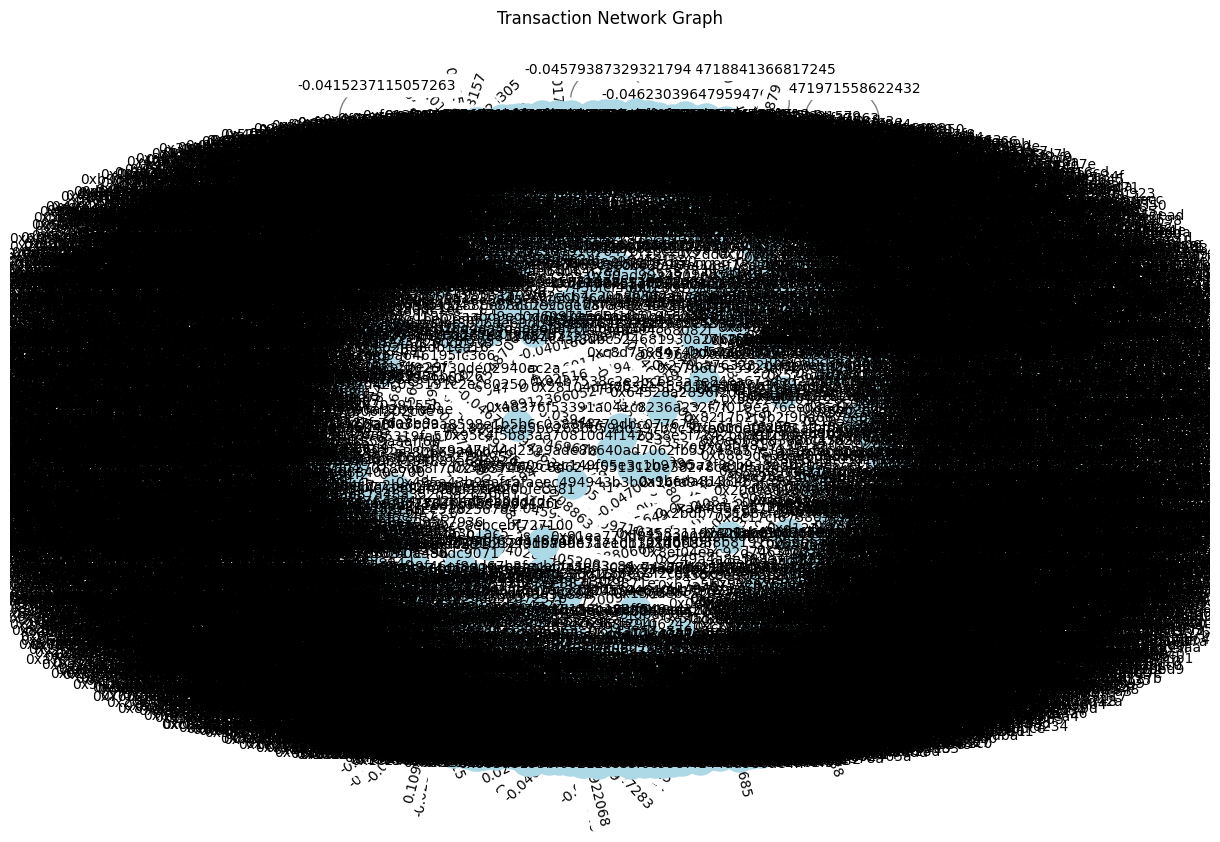

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create a directed graph
G = nx.DiGraph()

# Ensure 'Quantity' column is numeric (in case of any non-numeric data)
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')

# Add edges to the graph using 'From' and 'To' as nodes and 'Quantity' as the edge weight
for _, row in data.iterrows():
    G.add_edge(row['From'], row['To'], weight=row['Quantity'])

# Display basic graph information
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

# Visualize the graph (simple visualization for small graphs)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for node positioning
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=10,
    edge_color="gray"
)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Transaction Network Graph")
plt.show()


<Figure size 1200x800 with 0 Axes>

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [105.0, 105.0, 115.0, 115.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [195.0, 195.0, 214.375, 214.375],
  [185.0, 185.0, 204.6875, 204.6875],
  [175.0, 175.0, 194.84375, 194.84375],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [315.0, 315.0, 325.0, 325.0],
  [375.0, 375.0, 385.0, 385.0],
  [365.0, 365.0, 380.0, 380.0],
  [355.0, 355.0, 372.5, 372.5],
  [345.0, 345.0, 363.75, 363.75],
  [335.0, 335.0, 354.375, 354.375],
  [320.0, 320.0, 344.6875, 344.6875],
  [445.0, 445.0, 455.0, 455.0],
  [435.0, 435.0, 450.0, 450.0],
  [425.0, 425.0, 442.5, 442.5],
  [415.0, 415.0, 433.75, 433.75],
  [405.0, 405.0, 424.375, 424.375],
  [395.0, 395.0, 414.6875, 414.6875],
  [535.0, 535.0, 545.0, 545.0],
  [555.0, 555.0, 565.0, 565.0],


Text(0.5, 1.0, 'Hierarchical Clustering of Transaction Patterns')

Text(0.5, 0, 'From Addresses')

Text(0, 0.5, 'Distance')

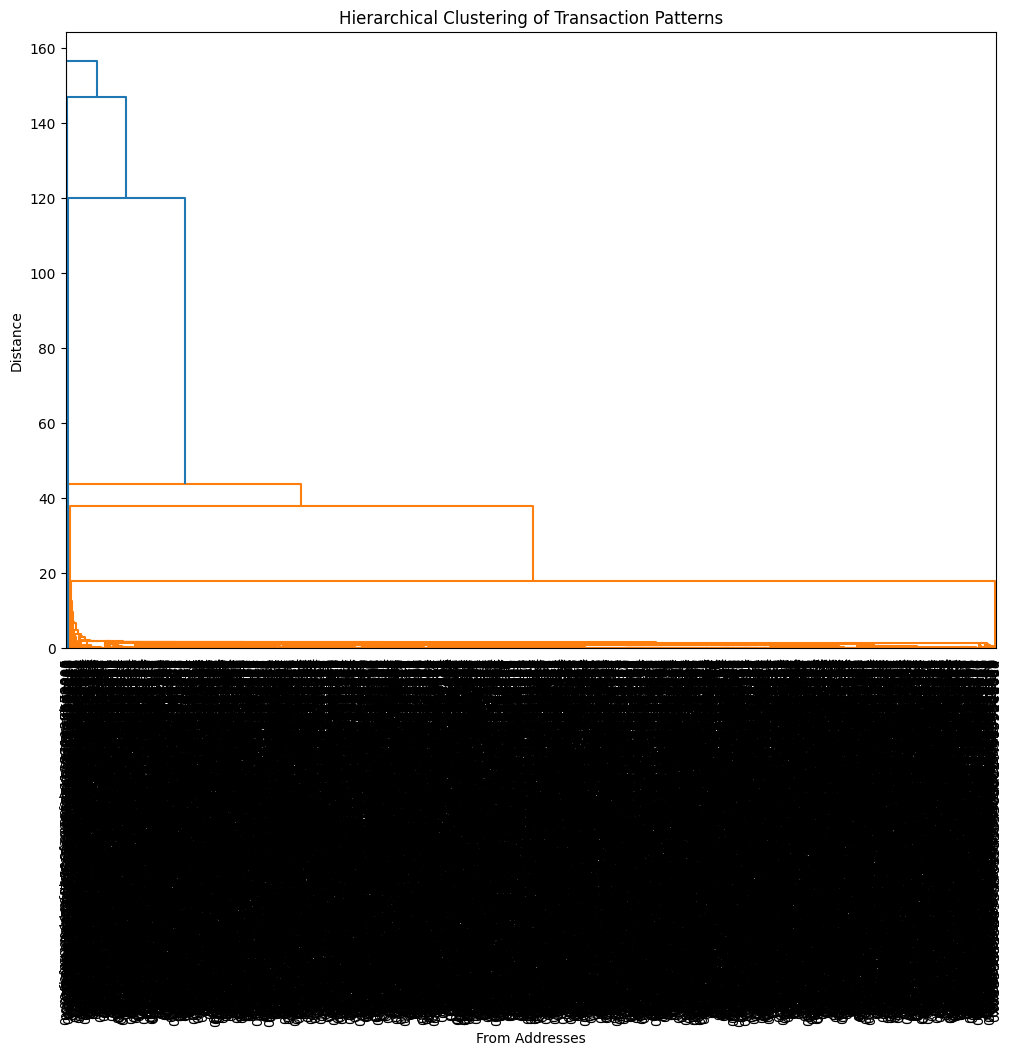

In [60]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Create a feature matrix based on transaction patterns
# Aggregating 'Quantity' by 'From' and 'To' addresses
feature_matrix = data.groupby(['From', 'To'])['Quantity'].sum().unstack(fill_value=0)

# Calculate the linkage matrix
# Using Ward's method to minimize variance within clusters
linkage_matrix = linkage(pdist(feature_matrix), method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=feature_matrix.index,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title("Hierarchical Clustering of Transaction Patterns")
plt.xlabel("From Addresses")
plt.ylabel("Distance")
plt.show()

<Figure size 800x600 with 0 Axes>

{'0x1111111254eeb25477b68fb85ed929f73a960582': Text(0.6689282103561426, 0.10905588524189999, '0x1111111254eeb25477b68fb85ed929f73a960582'),
 '0x983dfba1c0724786598af0e63a9a6f94aabd24a1': Text(0.7207008804603006, 0.4481104533678144, '0x983dfba1c0724786598af0e63a9a6f94aabd24a1'),
 '0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea': Text(-0.6743286711775356, 0.18984790017173783, '0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea'),
 '0x0000000000000000000000000000000000000000': Text(1.0, -0.26257717692159566, '0x0000000000000000000000000000000000000000'),
 '0xe37e799d5077682fa0a244d46e5649f71457bd09': Text(-0.23160637568268042, 0.3429062162439238, '0xe37e799d5077682fa0a244d46e5649f71457bd09'),
 '0x22f9dcf4647084d6c31b2765f6910cd85c178c18': Text(-0.6727399846323291, -0.3486743825897233, '0x22f9dcf4647084d6c31b2765f6910cd85c178c18'),
 '0x111111125421ca6dc452d289314280a0f8842a65': Text(-0.8066782413086587, -0.07833381152004723, '0x111111125421ca6dc452d289314280a0f8842a65'),
 '0x3fc91a3afd70395cd496c647d5

Text(0.5, 1.0, 'Subgraph of Top 10 Influential Nodes')

(-0.9845000838470344,
 1.094500003992716,
 -0.7791142418574311,
 0.8102790719901343)

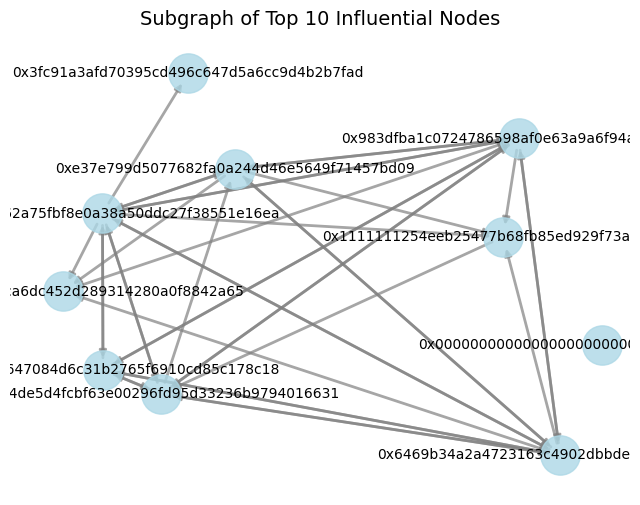

In [61]:
# Calculate degree centrality for each node
centrality = nx.degree_centrality(G)

# Create a DataFrame to store node centrality
centrality_df = pd.DataFrame(centrality.items(), columns=['Node', 'Centrality'])

# Sort the DataFrame by centrality in descending order
centrality_df = centrality_df.sort_values(by='Centrality', ascending=False)

# Extract subgraph for top 10 nodes by degree
top_nodes = centrality_df['Node'].head(10).tolist()
subgraph = G.subgraph(top_nodes)

# Visualize the subgraph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph, k=0.3)  # Layout for better spacing
nx.draw_networkx_nodes(subgraph, pos, node_size=800, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, width=2, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black')
plt.title("Subgraph of Top 10 Influential Nodes", fontsize=14)
plt.axis("off")
plt.show()

In [62]:
from sklearn.cluster import KMeans

# Use the same feature matrix from above
transaction_matrix = df.groupby(['From', 'To'])['Quantity'].sum().unstack(fill_value=0)

# Apply KMeans clustering
num_clusters = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
transaction_matrix['Cluster'] = kmeans.fit_predict(transaction_matrix)

# Display cluster assignments
print("Cluster Assignments:")
print(transaction_matrix[['Cluster']].head(10))


Cluster Assignments:
To                                          Cluster
From                                               
0x0000000000000000000000000000000000000000        2
0x00000000003b3cc22af3ae1eac0440bcee416b40        0
0x00000000009726632680fb29d3f7a9734e3010e2        0
0x00000000009e50a7ddb7a7b0e2ee6604fd120e49        0
0x000000000c1500d6cf5a65167f131a53c82c1033        0
0x000000000c56e91f092023d942aee89b3cc089ff        0
0x000000000dfde7deaf24138722987c9a6991e2d4        0
0x00000000a991c429ee2ec6df19d40fe0c80088b8        0
0x00000047bb99ea4d791bb749d970de71ee0b1a34        0
0x000000d40b595b94918a28b27d1e2c66f43a51d3        0


#isolation model

In [66]:
# Calculate centrality metrics using NetworkX
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Convert centrality metrics into DataFrame
centrality_df = pd.DataFrame({
    'Node': list(degree_centrality.keys()),
    'Degree_Centrality': list(degree_centrality.values()),
    'Betweenness_Centrality': list(betweenness_centrality.values()),
    'Closeness_Centrality': list(closeness_centrality.values())
})

# Merge centrality metrics with the original data
data = pd.merge(data, centrality_df, left_on='From', right_on='Node', how='left')

In [67]:
data.columns

Index(['Transaction Hash', 'Blockno', 'UnixTimestamp', 'DateTime (UTC)',
       'From', 'To', 'Quantity', 'Method', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Day_Of_Week', 'Time_Diff', 'Quantity_Log', 'Quantity_Binned',
       'Is_Self_Trade', 'Is_Circular_Trade', 'Method_Label',
       'Rolling_Mean_Quantity', 'Rolling_Std_Quantity', 'Is_Outlier',
       'Quantity_Capped', 'Is_High_Activity', 'Transaction_Frequency',
       'Node_x', 'Degree_Centrality_x', 'Betweenness_Centrality_x',
       'Closeness_Centrality_x', 'Node_y', 'Degree_Centrality_y',
       'Betweenness_Centrality_y', 'Closeness_Centrality_y', 'Node',
       'Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality'],
      dtype='object')

In [150]:
data.to_csv('features_data.csv', index=False)

In [ ]:
data.isnull().sum()

,0
Transaction Hash,0
Blockno,0
UnixTimestamp,0
DateTime (UTC),0
From,0
To,0
Quantity,0
Method,0
Year,0
Month,0


In [99]:
data_iof=data.copy()

In [101]:
features_to_use = [
    'Quantity',
    'Quantity_Log',
    'Time_Diff',
    'Rolling_Mean_Quantity',
    'Rolling_Std_Quantity',
    'Is_Self_Trade',
    'Is_Circular_Trade',
    'Is_High_Activity',
    'Quantity_Capped',
    'Degree_Centrality',
    'Betweenness_Centrality',
    'Closeness_Centrality'
]

X = data_iof[features_to_use]

# Handle missing values by filling them with the column's median
X = X.fillna(X.median())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (80% training, 20% testing)
X_train, X_test = train_test_split(X_scaled , test_size=0.2, random_state=42)

rng = np.random.RandomState(42)

# Initialize the Isolation Forest model with the provided parameters
model_if = IsolationForest(n_estimators=100,contamination=0.02,random_state=rng)

model_if.fit(X_train)

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_predictions = model_if.predict(X_scaled )

# Add anomaly predictions to the original data
data_iof['Anomaly'] = anomaly_predictions

# Get the anomaly scores (the lower the score, the more abnormal)
anomaly_scores = model_if.decision_function(X_scaled )

# Add the anomaly scores to the data
data_iof['Anomaly_Score'] = anomaly_scores

# View the data with anomaly scores
print(data_iof[['Quantity', 'Rolling_Std_Quantity', 'Anomaly', 'Anomaly_Score']].head())

IsolationForest(contamination=0.02,
                random_state=RandomState(MT19937) at 0x78B6A173E440)

   Quantity  Rolling_Std_Quantity  Anomaly  Anomaly_Score
0 -0.042631            458.861900        1       0.147280
1 -0.034090            458.861900        1       0.206395
2 -0.047191            458.861900        1       0.210039
3 -0.034090            458.861900        1       0.118849
4 -0.045921             50.717709        1       0.216163


In [102]:
# Print anomaly statistics
print(data_iof['Anomaly'].value_counts())

Anomaly
 1    19420
-1      416
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Time_Diff', ylabel='Quantity'>

Text(0.5, 1.0, 'Anomaly Detection in ERC20 Transactions')

Text(0.5, 0, 'Time Difference')

Text(0, 0.5, 'Quantity')

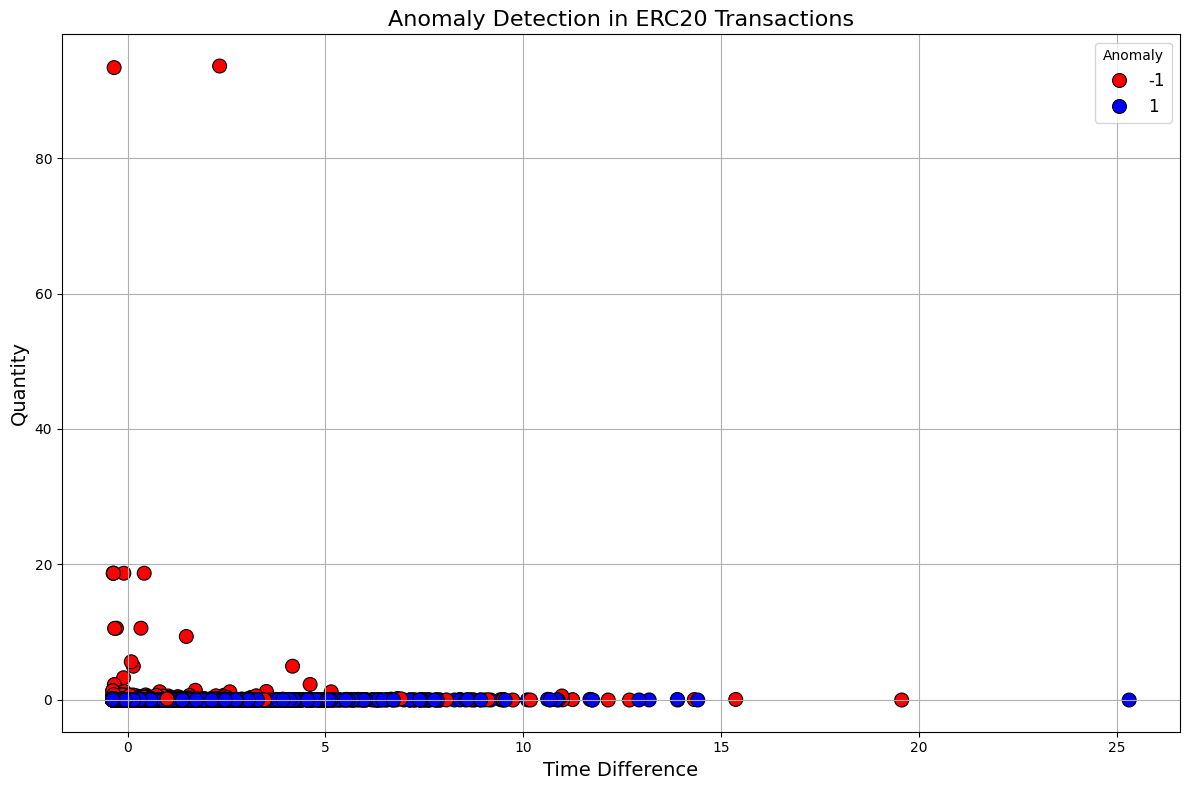

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize anomalies clearly using 'Time_Diff' and 'Quantity' columns
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data_iof, x='Time_Diff', y='Quantity', hue='Anomaly', palette={1: 'blue', -1: 'red'}, s=100, edgecolor='k')

# Set title and labels
plt.title('Anomaly Detection in ERC20 Transactions', fontsize=16)
plt.xlabel('Time Difference', fontsize=14)
plt.ylabel('Quantity', fontsize=14)

# Add a legend to distinguish anomalies
plt.legend(title='Anomaly', loc='upper right', fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

def outlier_plot(data_iof, outlier_method_name, x_var, y_var,
                 xaxis_limits=None, yaxis_limits=None):
    print(f'Outlier Method: {outlier_method_name}')


    if 'Anomaly' not in data_iof.columns:
        raise ValueError("The 'Anomaly' column is not present in the dataset.")

    # Print anomaly counts
    print(f"Number of anomalous values: {len(data_iof[data_iof['Anomaly'] == -1])}")
    print(f"Number of non-anomalous values: {len(data_iof[data_iof['Anomaly'] == 1])}")
    print(f'Total Number of Values: {len(data_iof)}')

    # Create the FacetGrid plot
    try:
        g = sns.FacetGrid(data_iof, col='Anomaly', height=4, hue='Anomaly', hue_order=[-1, 1])
        g.map(sns.scatterplot, x_var, y_var, alpha=0.7, s=50)
        g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.05, fontweight='bold')

        # Set axis limits if specified
        if xaxis_limits:
            g.set(xlim=xaxis_limits)
        if yaxis_limits:
            g.set(ylim=yaxis_limits)

        # Customize subplot titles
        axes = g.axes.flatten()
        if len(axes) > 0:
            axes[0].set_title(f"Outliers\n{len(data_iof[data_iof['Anomaly'] == -1])} points")
        if len(axes) > 1:
            axes[1].set_title(f"Inliers\n{len(data_iof[data_iof['Anomaly'] == 1])} points")
    except IndexError:
        print("Error: Expected categories in 'Anomaly' column are missing or incorrect.")
        return None

    return g


Outlier Method: Isolation Forest
Number of anomalous values: 416
Number of non-anomalous values: 19420
Total Number of Values: 19836


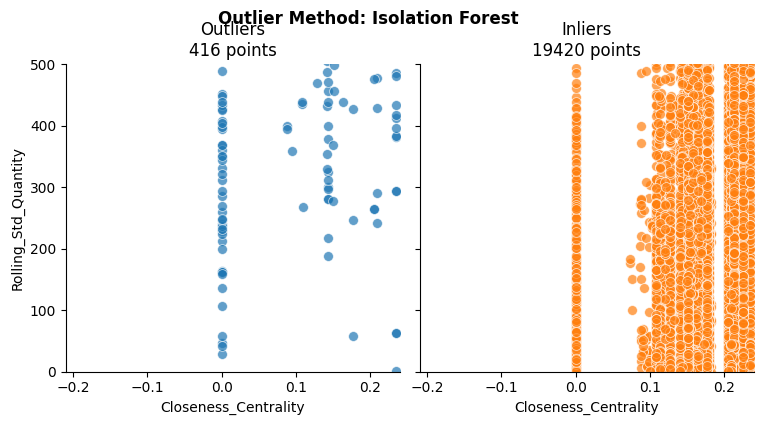

In [106]:

outlier_plot(data_iof, 'Isolation Forest', 'Closeness_Centrality', 'Rolling_Std_Quantity',
             xaxis_limits=[-0.21,0.24], yaxis_limits=[0,500])

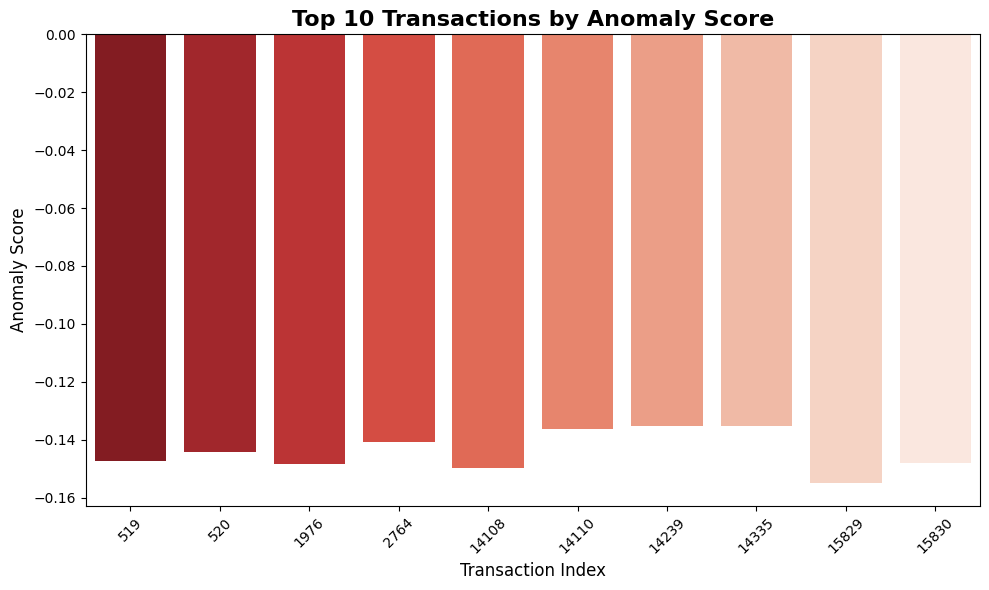

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_top_anomalies(data_iof, score_column, top_n=10):
    # Sort the data by anomaly score in ascending order (more anomalous first)
    top_anomalies = data_iof.nsmallest(top_n, score_column)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_anomalies,
        x=top_anomalies.index,
        y=score_column,
        palette="Reds_r"
    )
    plt.title(f'Top {top_n} Transactions by Anomaly Score', fontsize=16, fontweight='bold')
    plt.xlabel('Transaction Index', fontsize=12)
    plt.ylabel('Anomaly Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage example
visualize_top_anomalies(data_iof, 'Anomaly_Score', top_n=10)


feature importance


<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Feature Importance in Anomaly Detection')

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Features')

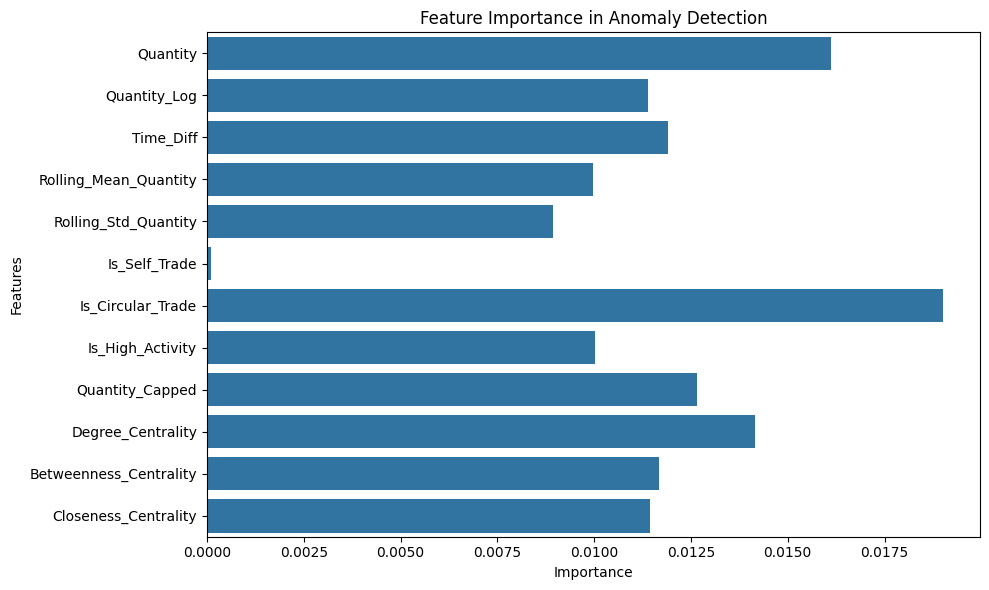

In [109]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to compute permutation feature importance manually
def compute_permutation_importance(model, X, feature_indices, n_repeats=10):
    baseline_scores = model.decision_function(X)
    feature_importances = np.zeros(len(feature_indices))

    for i, feature_idx in enumerate(feature_indices):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, feature_idx] = shuffle(X[:, feature_idx], random_state=42)
            permuted_scores = model.decision_function(X_permuted)
            scores.append(np.mean(np.abs(baseline_scores - permuted_scores)))
        feature_importances[i] = np.mean(scores)

    return feature_importances


feature_indices = list(range(X_scaled.shape[1])) # Get indices for all features

# Compute feature importance
feature_importance = compute_permutation_importance(
    model_if, X_scaled[:, feature_indices], feature_indices
)

features = [features_to_use[i] for i in feature_indices]

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features, orient="h")
plt.title('Feature Importance in Anomaly Detection')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [139]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid for Isolation Forest
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': ['auto', 0.5, 0.7, 0.8],
    'contamination': [0.01, 0.05, 0.1, 0.15],
    'max_features': [1.0, 0.5, 0.8],
    'random_state': [42]
}

# Select the relevant features
X = data_iof[[
    'Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
    'Rolling_Std_Quantity', 'Is_Self_Trade','Is_Circular_Trade',
    'Is_High_Activity', 'Quantity_Capped','Degree_Centrality',
    'Betweenness_Centrality', 'Closeness_Centrality'
]]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create the Isolation Forest model
iso_forest = IsolationForest()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=iso_forest,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error', # Scoring metric for model evaluation
    random_state=42,
    n_jobs=-1 # Use all available CPU cores for parallel processing
)

# Fit the model with the parameter grid
random_search.fit(X_scaled)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)

# Access the best model from the random search
best_iso_forest = random_search.best_estimator_

# Predict anomalies (1 for inliers, -1 for anomalies)
anomaly_predictions = best_iso_forest.predict(X_scaled)

# Convert anomaly predictions to binary (1 for inliers, -1 for outliers)
data_iof.loc[:, 'Anomaly'] = np.where(anomaly_predictions == 1, 1, -1)

# Get the anomaly scores
data_iof.loc[:, 'Anomaly_Score'] = best_iso_forest.decision_function(X_scaled)

# View the data with anomaly scores
print(data_iof[['Quantity', 'Time_Diff', 'Anomaly', 'Anomaly_Score']].head())


RandomizedSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
                   param_distributions={'contamination': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_features': [1.0, 0.5, 0.8],
                                        'max_samples': ['auto', 0.5, 0.7, 0.8],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42]},
                   random_state=42, scoring='neg_mean_squared_error')

Best parameters found:  {'random_state': 42, 'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.8, 'contamination': 0.01}
   Quantity  Time_Diff  Anomaly  Anomaly_Score
0 -0.042631  -0.375723        1       0.117503
1 -0.034090  -0.065674        1       0.147690
2 -0.047191  -0.375723        1       0.178639
3 -0.034090  -0.375723        1       0.104345
4 -0.045921   0.086425        1       0.133920


In [140]:
data_iof.columns

Index(['Transaction Hash', 'Blockno', 'UnixTimestamp', 'DateTime (UTC)',
       'From', 'To', 'Quantity', 'Method', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Day_Of_Week', 'Time_Diff', 'Quantity_Log', 'Quantity_Binned',
       'Is_Self_Trade', 'Is_Circular_Trade', 'Method_Label',
       'Rolling_Mean_Quantity', 'Rolling_Std_Quantity', 'Is_Outlier',
       'Quantity_Capped', 'Is_High_Activity', 'Transaction_Frequency',
       'Node_x', 'Degree_Centrality_x', 'Betweenness_Centrality_x',
       'Closeness_Centrality_x', 'Node_y', 'Degree_Centrality_y',
       'Betweenness_Centrality_y', 'Closeness_Centrality_y', 'Node',
       'Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality',
       'Anomaly', 'Anomaly_Score'],
      dtype='object')

In [141]:
# Print anomaly statistics
print(data_iof['Anomaly'].value_counts())

Anomaly
 1    19637
-1      199
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Time_Diff', ylabel='Quantity'>

Text(0.5, 1.0, 'Anomaly Detection in ERC20 Transactions')

Text(0.5, 0, 'Time Difference')

Text(0, 0.5, 'Quantity')

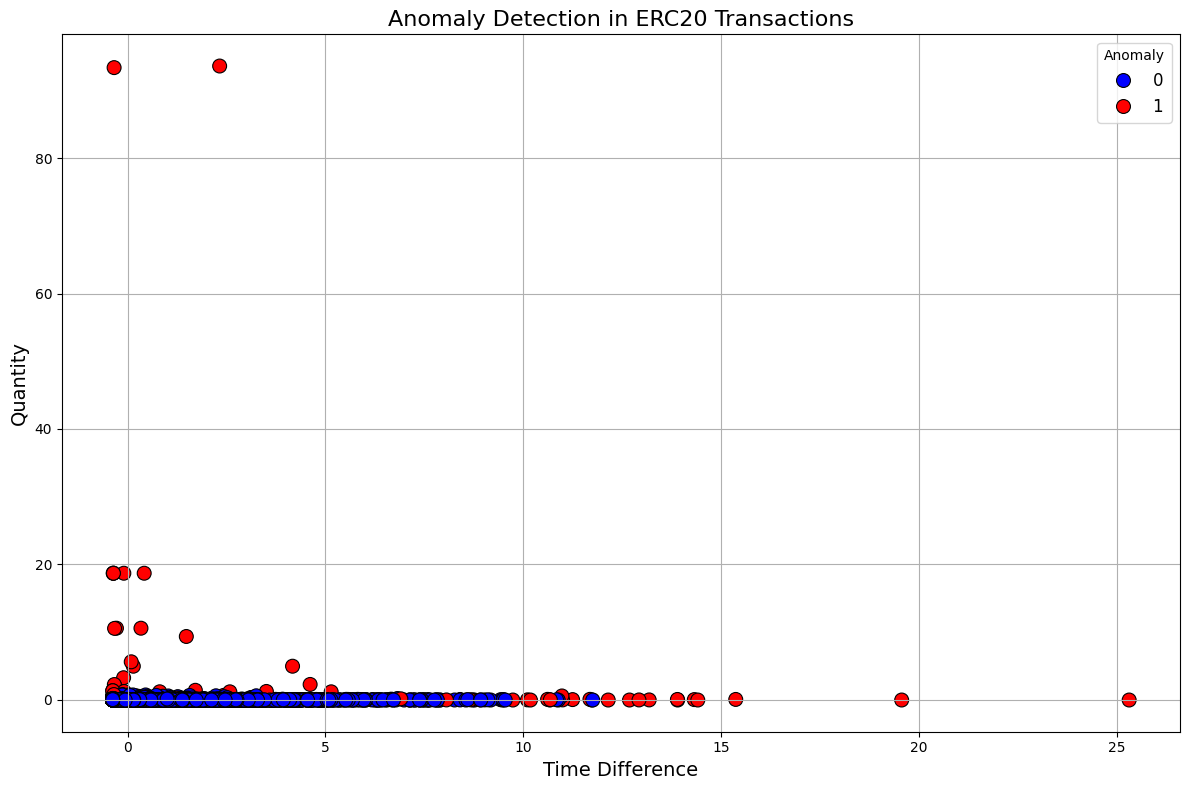

In [114]:
# Visualize anomalies
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_iof,
    x='Time_Diff',
    y='Quantity',
    hue='Anomaly',
    palette={0: 'blue', 1: 'red'},
    s=100,
    edgecolor='k'
)
plt.title('Anomaly Detection in ERC20 Transactions', fontsize=16)
plt.xlabel('Time Difference', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.legend(title='Anomaly', loc='upper right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'random_state': 42, 'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.8, 'contamination': 0.01}


#generated isolation_forest_train_predictions.csv for ensembling


In [142]:
# Select the relevant columns for ensembling
isolation_forest_predictions = data_iof[['Anomaly', 'Anomaly_Score']].copy()

# Safely add the 'Input Data' column using .loc
isolation_forest_predictions.loc[:, 'Input Data'] = data_iof.index

isolation_forest_predictions = isolation_forest_predictions[['Input Data', 'Anomaly', 'Anomaly_Score']]

# Save the updated data (with predictions) to a CSV file
isolation_forest_predictions.to_csv('isolation_forest_predictions.csv', index=False)

# Confirm that the file is saved
print("Isolation forest predictions with input data index saved to 'isolation_forest_predictions.csv'")


Isolation forest predictions with input data index saved to 'isolation_forest_predictions.csv'


In [117]:
data_iof.to_csv('final_data.csv', index=False)

#Testing


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

# Train your model on the scaled data
model = best_iso_forest
model.fit(X_scaled)

# Save the model and scaler
joblib.dump(model, 'iso_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler for later use


IsolationForest(contamination=0.01, max_features=0.8, max_samples=0.8,
                random_state=42)

['iso_forest_model.pkl']

['scaler.pkl']

In [ ]:
import pandas as pd

# Load the Excel file and get the sheet names
excel_file = '/content/drive/MyDrive/NEAR_token_transaction_data.xlsx'
xls = pd.ExcelFile(excel_file)

# Print sheet names
print(xls.sheet_names)


['export-token-0x85f17cf997934a59']


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import joblib

# Function to compute features based on user input
def extract_features(new_data, graph):
    new_data['Quantity_Log'] = np.log(new_data['Quantity'] + 1)


    new_data['UnixTimestamp'] = pd.to_datetime(new_data['UnixTimestamp'], unit='s')

    # Calculate time difference (in seconds)
    new_data['Time_Diff'] = new_data['UnixTimestamp'].diff().fillna(pd.Timedelta(0)).dt.total_seconds()

    # Rolling statistics
    new_data['Rolling_Mean_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).mean()
    new_data['Rolling_Std_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).std()

    # Identifying anomalies
    new_data['Is_Self_Trade'] = (new_data['From'] == new_data['To']).astype(int)
    new_data['Is_Circular_Trade'] = (new_data['From'].duplicated() & new_data['To'].duplicated()).astype(int)
    new_data['Is_High_Activity'] = (new_data['Quantity'] > new_data['Quantity'].quantile(0.75)).astype(int)
    new_data['Quantity_Capped'] = new_data['Quantity'].clip(upper=new_data['Quantity'].quantile(0.95))

    # Add centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Map centrality metrics to the new data
    new_data['Degree_Centrality'] = new_data['From'].map(degree_centrality).fillna(0)
    new_data['Betweenness_Centrality'] = new_data['From'].map(betweenness_centrality).fillna(0)
    new_data['Closeness_Centrality'] = new_data['From'].map(closeness_centrality).fillna(0)

    return new_data

# Load the pre-trained model and scaler
model = joblib.load('iso_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Rebuild the graph (based on training data)
data = pd.read_excel(excel_file, sheet_name='export-token-0x85f17cf997934a59')
G = nx.DiGraph()

# Add edges to the graph using training data
for _, row in data.iterrows():
    G.add_edge(row['From'], row['To'], weight=row['Quantity'])

# Input from the user
transaction_hash = '0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c'
blockno = 20107422
unix_timestamp = 1718577983
datetime_utc = '6/16/24 22:46'
from_address = '0xbc6a5cfcf24eacda3c25c042494ef21b77165738'
to_address = '0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea'
quantity = 300
method = 'Unoswap'

# Create a DataFrame from the user input
user_input_data = pd.DataFrame({
    'Transaction Hash': [transaction_hash],
    'Blockno': [blockno],
    'UnixTimestamp': [unix_timestamp],
    'DateTime (UTC)': [datetime_utc],
    'From': [from_address],
    'To': [to_address],
    'Quantity': [quantity],
    'Method': [method]
})

# Apply feature extraction to the user input
user_input_data = extract_features(user_input_data, G)

# Select the relevant features that were used during model training
X_user_input = user_input_data[['Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
                                'Rolling_Std_Quantity', 'Is_Self_Trade', 'Is_Circular_Trade',
                                'Is_High_Activity', 'Quantity_Capped', 'Degree_Centrality',
                                'Betweenness_Centrality', 'Closeness_Centrality']]

# Scale the features using the pre-trained scaler
X_user_input_scaled = scaler.transform(X_user_input)

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_prediction = model.predict(X_user_input_scaled)

# Convert anomaly prediction to binary (1 for outlier, 0 for inlier)
result = "Anomaly Detected" if anomaly_prediction[0] == 1 else "Normal Transaction"

# Display the result
print(f"Transaction Hash: {transaction_hash}")
print(f"Prediction: {result}")


Transaction Hash: 0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c
Prediction: Normal Transaction


#LOF Model

In [122]:
data= data.drop(['Anomaly', 'Anomaly_Score'], axis=1)

In [123]:
data_lof=data.copy()

In [124]:
data_lof.columns

Index(['Transaction Hash', 'Blockno', 'UnixTimestamp', 'DateTime (UTC)',
       'From', 'To', 'Quantity', 'Method', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Day_Of_Week', 'Time_Diff', 'Quantity_Log', 'Quantity_Binned',
       'Is_Self_Trade', 'Is_Circular_Trade', 'Method_Label',
       'Rolling_Mean_Quantity', 'Rolling_Std_Quantity', 'Is_Outlier',
       'Quantity_Capped', 'Is_High_Activity', 'Transaction_Frequency',
       'Node_x', 'Degree_Centrality_x', 'Betweenness_Centrality_x',
       'Closeness_Centrality_x', 'Node_y', 'Degree_Centrality_y',
       'Betweenness_Centrality_y', 'Closeness_Centrality_y', 'Node',
       'Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality'],
      dtype='object')

In [125]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# List of features to use
features_to_use = [
    'Quantity',
    'Quantity_Log',
    'Time_Diff',
    'Rolling_Mean_Quantity',
    'Rolling_Std_Quantity',
    'Is_Self_Trade',
    'Is_Circular_Trade',
    'Is_High_Activity',
    'Quantity_Capped',
    'Degree_Centrality',
    'Betweenness_Centrality',
    'Closeness_Centrality'
]


# Prepare the data and handle missing values
X = data_lof[features_to_use]
X = X.fillna(X.median())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (80% training, 20% testing)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Initialize the LOF model
lof_model = LocalOutlierFactor(
    n_neighbors=20,  # Number of neighbors to consider
    contamination=0.02,  # Approximate proportion of anomalies
    novelty=True  # Enables using the model for predictions after fitting
)

# Fit the model using the training set
lof_model.fit(X_train)

# Predict anomalies (-1 for anomalies, 1 for normal points)
anomaly_predictions = lof_model.predict(X_scaled)

# Get the anomaly scores (the lower, the more anomalous)
anomaly_scores = -lof_model.decision_function(X_scaled)

# Add anomaly predictions and scores to the original data
data_lof['LOF_Anomaly'] = anomaly_predictions
data_lof['LOF_Anomaly_Score'] = anomaly_scores

# Display the data with anomaly scores
print(data_lof[['Quantity', 'Rolling_Std_Quantity', 'LOF_Anomaly', 'LOF_Anomaly_Score']].head())

# Save anomalies to a file
anomalies = data_lof[data_lof['LOF_Anomaly'] == -1]
anomalies.to_csv('lof_anomalies.csv', index=False)

# Summary of anomalies
print(f"Total anomalies detected: {len(anomalies)}")


LocalOutlierFactor(contamination=0.02, novelty=True)

   Quantity  Rolling_Std_Quantity  LOF_Anomaly  LOF_Anomaly_Score
0 -0.042631            458.861900            1          -1.575797
1 -0.034090            458.861900            1          -1.770696
2 -0.047191            458.861900            1          -1.756850
3 -0.034090            458.861900            1          -1.770120
4 -0.045921             50.717709            1          -1.523510
Total anomalies detected: 341


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Index', ylabel='LOF_Anomaly_Score'>

Text(0.5, 1.0, 'LOF Scores and Anomaly Detection')

Text(0.5, 0, 'Transaction Index')

Text(0, 0.5, 'LOF Score')

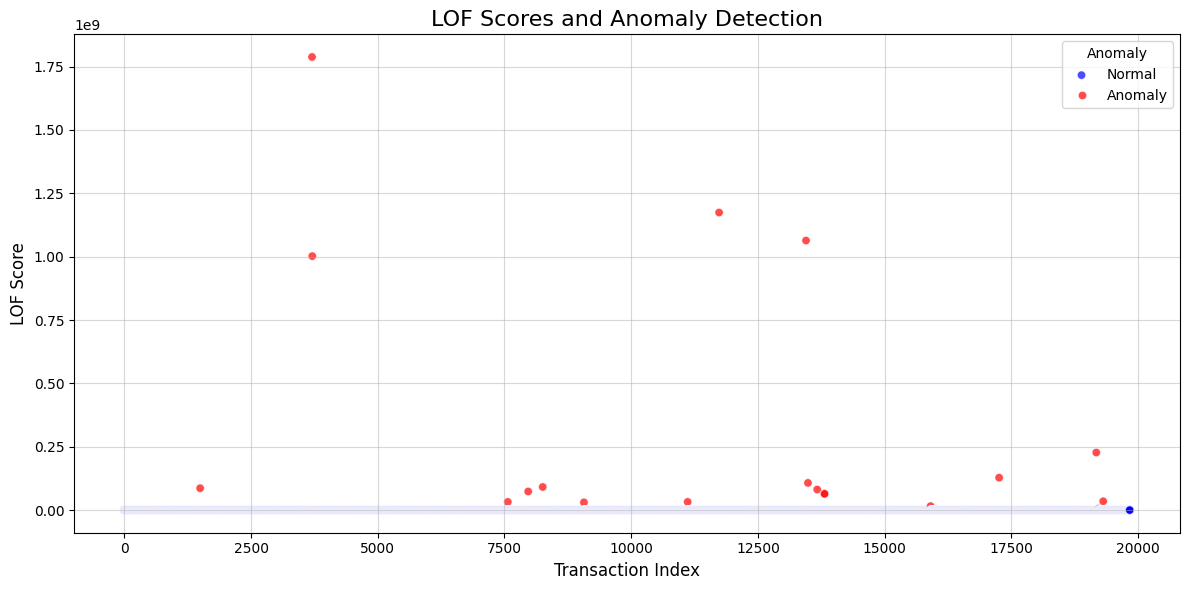

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

data_lof['Index'] = data_lof.index


plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_lof, x='Index', y='LOF_Anomaly_Score', hue='LOF_Anomaly',
                palette={1: 'blue', -1: 'red'}, alpha=0.7)

# Add plot labels and title
plt.title('LOF Scores and Anomaly Detection', fontsize=16)
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('LOF Score', fontsize=12)
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Time Difference (seconds)')

Text(0.5, 1.0, 'LOF Anomalies: Quantity vs. Time Difference')

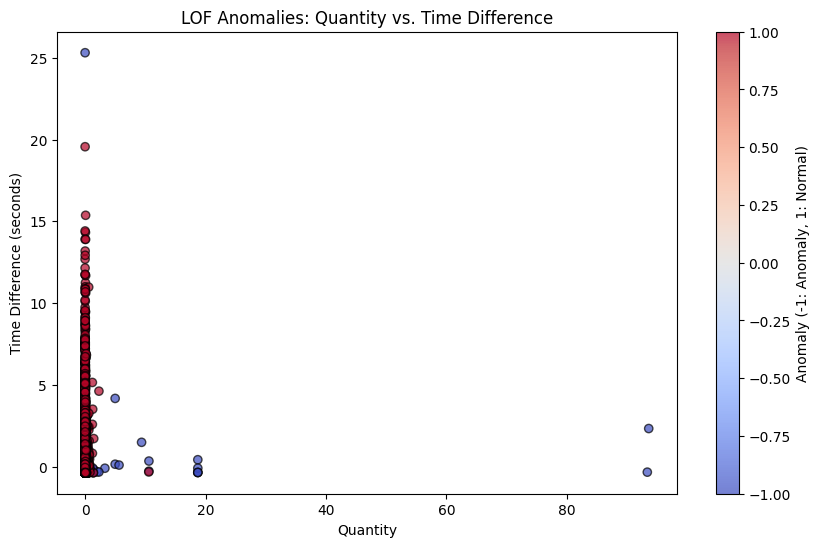

In [127]:
import matplotlib.pyplot as plt

# Scatter plot of Quantity vs. Time Diff
plt.figure(figsize=(10, 6))
plt.scatter(data_lof['Quantity'], data_lof['Time_Diff'], c=data_lof['LOF_Anomaly'], cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.colorbar(label='Anomaly (-1: Anomaly, 1: Normal)')
plt.xlabel('Quantity')
plt.ylabel('Time Difference (seconds)')
plt.title('LOF Anomalies: Quantity vs. Time Difference')
plt.show()


In [128]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Define the parameter grid for Local Outlier Factor
param_dist = {
    'n_neighbors': [35,45,55, 65, 75],  # Number of neighbors to consider
    'contamination': [0.01, 0.05, 0.1, 0.15],  # Expected fraction of outliers
}


# Select the relevant features
X = data[[
    'Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
    'Rolling_Std_Quantity', 'Is_Self_Trade', 'Is_Circular_Trade',
    'Is_High_Activity', 'Quantity_Capped', 'Degree_Centrality',
    'Betweenness_Centrality', 'Closeness_Centrality'
]]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a custom scoring function for Local Outlier Factor
def lof_score(estimator, X):
    # Fit the LOF model and calculate negative outlier factor
    estimator.fit(X)
    scores = -estimator.negative_outlier_factor_
    return np.mean(scores)

# Define a scorer for RandomizedSearchCV
scorer = make_scorer(lof_score, greater_is_better=True)

# Initialize the Local Outlier Factor model
lof_model = LocalOutlierFactor(novelty=True)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lof_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,  # Number of cross-validation folds
    scoring=scorer,  # Scoring metric for model evaluation
    random_state=42,  # Random state for reproducibility
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the model with the parameter grid
random_search.fit(X_scaled)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)

# Access the best model from the random search
best_lof_model = random_search.best_estimator_

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_predictions = best_lof_model.predict(X_scaled)

data_lof['LOF_Anomaly'] = np.where(anomaly_predictions == -1, 1, 0)

# Get the anomaly scores
data_lof['LOF_Anomaly_Score'] = -best_lof_model.decision_function(X_scaled)

# View the data with anomaly scores
print(data_lof[['Quantity', 'Time_Diff', 'LOF_Anomaly', 'LOF_Anomaly_Score']].head())


RandomizedSearchCV(cv=5, estimator=LocalOutlierFactor(novelty=True), n_jobs=-1,
                   param_distributions={'contamination': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'n_neighbors': [35, 45, 55, 65, 75]},
                   random_state=42,
                   scoring=make_scorer(lof_score, response_method='predict'))

Best parameters found:  {'n_neighbors': 35, 'contamination': 0.01}
   Quantity  Time_Diff  LOF_Anomaly  LOF_Anomaly_Score
0 -0.042631  -0.375723            0          -3.278928
1 -0.034090  -0.065674            0          -3.403966
2 -0.047191  -0.375723            0          -3.378581
3 -0.034090  -0.375723            0          -3.481567
4 -0.045921   0.086425            0          -3.166413


In [129]:
data_lof['LOF_Anomaly'].value_counts()

,count
LOF_Anomaly,
0,19654
1,182


In [130]:
# Use the best parameters
print(f"Best parameters found: {random_search.best_params_}")

Best parameters found: {'n_neighbors': 35, 'contamination': 0.01}


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Quantity')

Text(0, 0.5, 'Time Difference (seconds)')

Text(0.5, 1.0, 'LOF Anomalies: Quantity vs. Time Difference')

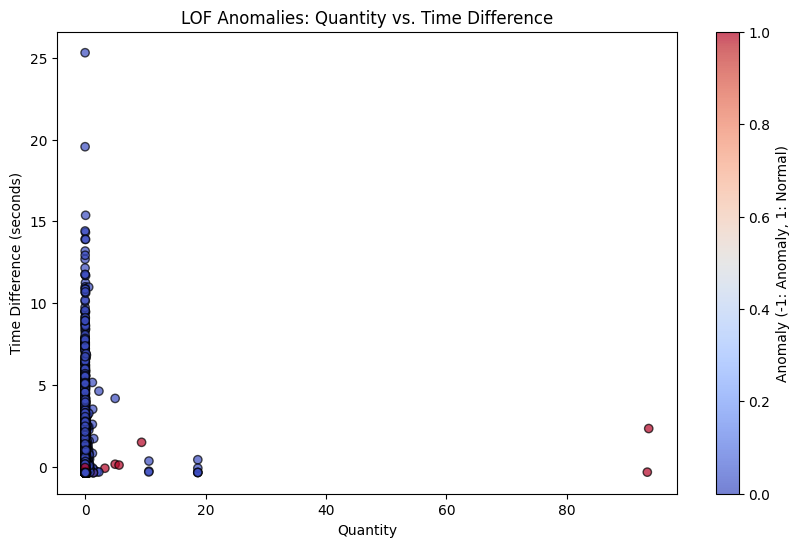

In [131]:
# Scatter plot of Quantity vs. Time Diff
plt.figure(figsize=(10, 6))
plt.scatter(data_lof['Quantity'], data_lof['Time_Diff'], c=data_lof['LOF_Anomaly'], cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.colorbar(label='Anomaly (-1: Anomaly, 1: Normal)')
plt.xlabel('Quantity')
plt.ylabel('Time Difference (seconds)')
plt.title('LOF Anomalies: Quantity vs. Time Difference')
plt.show()

#Generating CSV file for LOF Predictions


In [132]:
lof_predictions = pd.DataFrame({
    'Input Data': data_lof.index,
    'LOF_Anomaly': best_lof_model.predict(X_scaled),
    'LOF_Anomaly_Score': -best_lof_model.decision_function(X_scaled)
})

# Select columns in desired order
lof_predictions = lof_predictions[['Input Data', 'LOF_Anomaly', 'LOF_Anomaly_Score']]

# Save to a CSV file
lof_predictions.to_csv('LOF_train_predictions.csv', index=False)

# Confirm file saved
print("LOF predictions with input data index saved to 'LOF_train_predictions.csv'")


LOF predictions with input data index saved to 'LOF_train_predictions.csv'


#Testing

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

model = best_lof_model
model.fit(X_scaled)  # Fit the LOF model to the scaled data

# Save the model
joblib.dump(model, 'lof_model.pkl')

joblib.dump(scaler, 'scaler.pkl')

print("LOF model and scaler have been saved successfully.")


LocalOutlierFactor(contamination=0.01, n_neighbors=35, novelty=True)

['lof_model.pkl']

['scaler.pkl']

LOF model and scaler have been saved successfully.


In [ ]:
# Load the Excel file and get the sheet names
excel_file = '/content/drive/MyDrive/infosys/project/NEAR_token_transaction_data.xlsx'
xls = pd.ExcelFile(excel_file)

# Print sheet names
print(xls.sheet_names)


['export-token-0x85f17cf997934a59']


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import joblib

# Function to compute features based on user input
def extract_features(new_data, graph):
    # Handle potential NaN in Quantity before log transformation
    new_data['Quantity'] = pd.to_numeric(new_data['Quantity'], errors='coerce').fillna(0)
    new_data['Quantity_Log'] = np.log1p(new_data['Quantity'])  # Use log1p to handle 0 values


    new_data['UnixTimestamp'] = pd.to_datetime(new_data['UnixTimestamp'], unit='s', errors='coerce')

    # Calculate time difference (in seconds) and fill NaN with 0
    new_data['Time_Diff'] = new_data['UnixTimestamp'].diff().fillna(pd.Timedelta(0)).dt.total_seconds()

    # Rolling statistics, fill NaN with 0
    new_data['Rolling_Mean_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).mean().fillna(0)
    new_data['Rolling_Std_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).std().fillna(0)

    # Identifying anomalies
    new_data['Is_Self_Trade'] = (new_data['From'] == new_data['To']).astype(int)
    new_data['Is_Circular_Trade'] = (new_data['From'].duplicated() & new_data['To'].duplicated()).astype(int)
    new_data['Is_High_Activity'] = (new_data['Quantity'] > new_data['Quantity'].quantile(0.75)).astype(int)
    new_data['Quantity_Capped'] = new_data['Quantity'].clip(upper=new_data['Quantity'].quantile(0.95))

    # Add centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Map centrality metrics to the new data and fill NaN with 0
    new_data['Degree_Centrality'] = new_data['From'].map(degree_centrality).fillna(0)
    new_data['Betweenness_Centrality'] = new_data['From'].map(betweenness_centrality).fillna(0)
    new_data['Closeness_Centrality'] = new_data['From'].map(closeness_centrality).fillna(0)

    return new_data

# Load the pre-trained model and scaler
model = joblib.load('/content/lof_model.pkl')
scaler = joblib.load('/content/scaler.pkl')

# Rebuild the graph (based on training data)
data = pd.read_excel(excel_file, sheet_name='export-token-0x85f17cf997934a59')
G = nx.DiGraph()

# Add edges to the graph using training data
for _, row in data.iterrows():
    G.add_edge(row['From'], row['To'], weight=row['Quantity'])

# Input from the user
transaction_hash = '0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c'
blockno = 20107422
unix_timestamp = 1718577983
datetime_utc = '6/16/24 22:46'
from_address = '0xbc6a5cfcf24eacda3c25c042494ef21b77165738'
to_address = '0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea'
quantity = 300
method = 'Unoswap'

# Create a DataFrame from the user input
user_input_data = pd.DataFrame({
    'Transaction Hash': [transaction_hash],
    'Blockno': [blockno],
    'UnixTimestamp': [unix_timestamp],
    'DateTime (UTC)': [datetime_utc],
    'From': [from_address],
    'To': [to_address],
    'Quantity': [quantity],
    'Method': [method]
})

# Apply feature extraction to the user input
user_input_data = extract_features(user_input_data, G)

# Select the relevant features that were used during model training
X_user_input = user_input_data[['Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
                                'Rolling_Std_Quantity', 'Is_Self_Trade', 'Is_Circular_Trade',
                                'Is_High_Activity', 'Quantity_Capped', 'Degree_Centrality',
                                'Betweenness_Centrality', 'Closeness_Centrality']]

# Scale the features using the pre-trained scaler
X_user_input_scaled = scaler.transform(X_user_input)

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_prediction = model.predict(X_user_input_scaled)

# Convert anomaly prediction to binary (1 for outlier, 0 for inlier)
result = "Anomaly Detected" if anomaly_prediction[0] == 1 else "Normal Transaction"

# Display the result
print(f"Transaction Hash: {transaction_hash}")
print(f"Prediction: {result}")

Transaction Hash: 0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c
Prediction: Normal Transaction


In [ ]:
data_lof.to_csv('data_lof.csv', index=False)

# One Class SVM

In [68]:
data_svm=data.copy()

In [91]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X = data_svm[['Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
    'Rolling_Std_Quantity', 'Is_Self_Trade', 'Is_Circular_Trade',
    'Is_High_Activity', 'Quantity_Capped', 'Degree_Centrality',
    'Betweenness_Centrality', 'Closeness_Centrality']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the One-Class SVM model
model_ocsvm = OneClassSVM(nu=0.02, kernel='rbf', gamma='scale')

# Fit the model on the data
model_ocsvm.fit(X_scaled)

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_predictions = model_ocsvm.predict(X_scaled)

# Get the anomaly scores
anomaly_scores = model_ocsvm.decision_function(X_scaled)

# Add the anomaly predictions and anomaly scores to the data
data_svm['Anomaly_OCSVM'] = anomaly_predictions
data_svm['Anomaly_Score_OCSVM'] = anomaly_scores

# Optionally, you can print a few rows to verify the data
print(data_svm[['Quantity', 'Anomaly_OCSVM', 'Anomaly_Score_OCSVM']].head())


OneClassSVM(nu=0.02)

   Quantity  Anomaly_OCSVM  Anomaly_Score_OCSVM
0 -0.042631              1             1.656910
1 -0.034090              1             2.732254
2 -0.047191              1             0.267471
3 -0.034090              1             3.660918
4 -0.045921              1             2.995798


In [92]:
data_svm['Anomaly_OCSVM'].value_counts()

,count
Anomaly_OCSVM,
1,19437
-1,399


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None', ylabel='Anomaly_Score_OCSVM'>

Text(0.5, 1.0, 'Anomaly Scores and Predictions with One-Class SVM')

Text(0.5, 0, 'Transaction Index')

Text(0, 0.5, 'Anomaly Score')

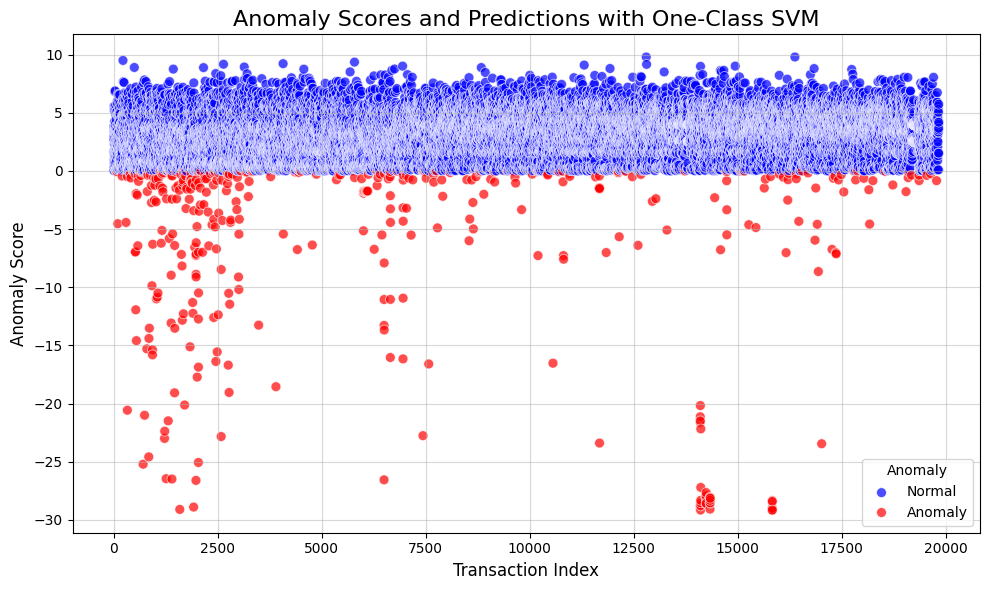

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the anomaly scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_svm.index, y=data_svm['Anomaly_Score_OCSVM'], hue=data_svm['Anomaly_OCSVM'],
                palette={1: 'blue', -1: 'red'}, alpha=0.7, s=50)
plt.title('Anomaly Scores and Predictions with One-Class SVM', fontsize=16)
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None'>

Text(0.5, 1.0, 'Decision Function of One-Class SVM')

Text(0.5, 0, 'Transaction Index')

Text(0, 0.5, 'Decision Function Value')

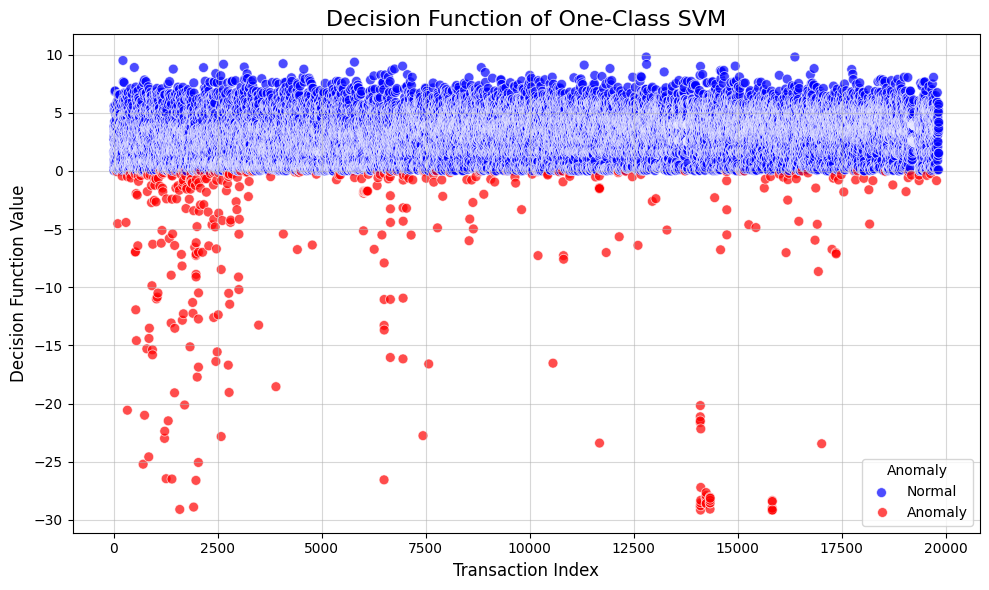

In [98]:
# Visualizing the decision function
# Get the decision function (distance from the separating hyperplane)
decision_function = model_ocsvm.decision_function(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_svm.index, y=decision_function, hue=data_svm['Anomaly_OCSVM'],
                palette={1: 'blue', -1: 'red'}, alpha=0.7, s=50)
plt.title('Decision Function of One-Class SVM', fontsize=16)
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('Decision Function Value', fontsize=12)
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

#Generating svm_predictions.csv

In [133]:
svm_predictions = pd.DataFrame({
    'Input Data': data_svm.index,
    'SVM_Anomaly': model_ocsvm.predict(X_scaled),
    'SVM_Anomaly_Score': -model_ocsvm.decision_function(X_scaled)
})

# Select columns in desired order
svm_predictions = svm_predictions[['Input Data', 'SVM_Anomaly', 'SVM_Anomaly_Score']]

# Save to a CSV file
svm_predictions.to_csv('SVM_train_predictions.csv', index=False)

# Confirm file saved
print("SVM predictions with input data index saved to 'SVM_train_predictions.csv'")


SVM predictions with input data index saved to 'SVM_train_predictions.csv'


#Testing


In [164]:
from sklearn.preprocessing import StandardScaler
import joblib

model = model_ocsvm
model.fit(X_scaled)  # Fit the svm model to the scaled data

# Save the model
joblib.dump(model, 'svm_model.pkl')

joblib.dump(scaler, 'scaler.pkl')  # Save the scaler for later use

print("svm model and scaler have been saved successfully.")


OneClassSVM(nu=0.02)

['svm_model.pkl']

['scaler.pkl']

svm model and scaler have been saved successfully.


In [165]:
# Load the Excel file and get the sheet names
excel_file = '/content/drive/MyDrive/infosys/project/NEAR_token_transaction_data.xlsx'
xls = pd.ExcelFile(excel_file)

# Print sheet names
print(xls.sheet_names)


['export-token-0x85f17cf997934a59']


In [167]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
import joblib

# Function to compute features based on user input
def extract_features(new_data, graph):
    # Handle potential NaN in Quantity before log transformation
    new_data['Quantity'] = pd.to_numeric(new_data['Quantity'], errors='coerce').fillna(0)
    new_data['Quantity_Log'] = np.log1p(new_data['Quantity'])  # Use log1p to handle 0 values

    new_data['UnixTimestamp'] = pd.to_datetime(new_data['UnixTimestamp'], unit='s', errors='coerce')

    # Calculate time difference (in seconds) and fill NaN with 0
    new_data['Time_Diff'] = new_data['UnixTimestamp'].diff().fillna(pd.Timedelta(0)).dt.total_seconds()

    # Rolling statistics, fill NaN with 0
    new_data['Rolling_Mean_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).mean().fillna(0)
    new_data['Rolling_Std_Quantity'] = new_data['Quantity'].rolling(window=5, min_periods=1).std().fillna(0)

    # Identifying anomalies
    new_data['Is_Self_Trade'] = (new_data['From'] == new_data['To']).astype(int)
    new_data['Is_Circular_Trade'] = (new_data['From'].duplicated() & new_data['To'].duplicated()).astype(int)
    new_data['Is_High_Activity'] = (new_data['Quantity'] > new_data['Quantity'].quantile(0.75)).astype(int)
    new_data['Quantity_Capped'] = new_data['Quantity'].clip(upper=new_data['Quantity'].quantile(0.95))

    # Add centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Map centrality metrics to the new data and fill NaN with 0
    new_data['Degree_Centrality'] = new_data['From'].map(degree_centrality).fillna(0)
    new_data['Betweenness_Centrality'] = new_data['From'].map(betweenness_centrality).fillna(0)
    new_data['Closeness_Centrality'] = new_data['From'].map(closeness_centrality).fillna(0)

    return new_data

# Load the pre-trained model and scaler
model = joblib.load('/content/svm_model.pkl')
scaler = joblib.load('/content/scaler.pkl')

# Rebuild the graph (based on training data)
data = pd.read_excel(excel_file, sheet_name='export-token-0x85f17cf997934a59')
G = nx.DiGraph()

# Add edges to the graph using training data
for _, row in data.iterrows():
    G.add_edge(row['From'], row['To'], weight=row['Quantity'])

# Input from the user
transaction_hash = '0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c'
blockno = 20107422
unix_timestamp = 1718577983
datetime_utc = '6/16/24 22:46'
from_address = '0xbc6a5cfcf24eacda3c25c042494ef21b77165738'
to_address = '0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea'
quantity = 300
method = 'Unoswap'

# Create a DataFrame from the user input
user_input_data = pd.DataFrame({
    'Transaction Hash': [transaction_hash],
    'Blockno': [blockno],
    'UnixTimestamp': [unix_timestamp],
    'DateTime (UTC)': [datetime_utc],
    'From': [from_address],
    'To': [to_address],
    'Quantity': [quantity],
    'Method': [method]
})

# Apply feature extraction to the user input
user_input_data = extract_features(user_input_data, G)

# Select the relevant features that were used during model training
X_user_input = user_input_data[['Quantity', 'Quantity_Log', 'Time_Diff', 'Rolling_Mean_Quantity',
                                'Rolling_Std_Quantity', 'Is_Self_Trade', 'Is_Circular_Trade',
                                'Is_High_Activity', 'Quantity_Capped', 'Degree_Centrality',
                                'Betweenness_Centrality', 'Closeness_Centrality']]

# Scale the features using the pre-trained scaler
X_user_input_scaled = scaler.transform(X_user_input)

# Predict anomalies (1 for normal, -1 for anomaly)
anomaly_prediction = model.predict(X_user_input_scaled)

# Convert anomaly prediction to binary (1 for outlier, 0 for inlier)
result = "Anomaly Detected" if anomaly_prediction[0] == 1 else "Normal Transaction"

# Display the result
print(f"Transaction Hash: {transaction_hash}")
print(f"Prediction: {result}")

Transaction Hash: 0x2fc6a64eced2193850c860653a7a81944c227079370d40ca8dcea39043adfe4c
Prediction: Normal Transaction


#Ensemble

In [145]:
import pandas as pd

# Load predictions from each model's CSV file
lof_predictions = pd.read_csv('/content/LOF_train_predictions.csv')  # LOF model predictions
if_predictions = pd.read_csv('/content/isolation_forest_predictions.csv')  # Isolation Forest model predictions
ocsvm_predictions = pd.read_csv('/content/SVM_train_predictions.csv')  # One-Class SVM model predictions

# Ensure the relevant columns are available (adjust column names if needed)
lof_predictions['LOF_Anomaly'] = lof_predictions['LOF_Anomaly'].astype(int)
if_predictions['Anomaly'] = if_predictions['Anomaly'].astype(int)
ocsvm_predictions['SVM_Anomaly'] = ocsvm_predictions['SVM_Anomaly'].astype(int)

# Merge the DataFrames based on the index
ensemble_predictions = lof_predictions[['Input Data', 'LOF_Anomaly']].merge(
    if_predictions[['Input Data', 'Anomaly']], on='Input Data', how='left').merge(
    ocsvm_predictions[['Input Data', 'SVM_Anomaly']], on='Input Data', how='left')

# Apply majority voting to determine final anomaly label
ensemble_predictions['Final_Anomaly'] = ensemble_predictions.apply(
    lambda row: -1 if (row['LOF_Anomaly'] == -1) or (row['Anomaly'] == -1) or (row['SVM_Anomaly'] == -1) else 1,
    axis=1
)

# Save the final results to a new CSV file
ensemble_predictions.to_csv('Ensembled_Anomaly_Predictions.csv', index=False)

# Display a message to indicate successful completion
print("Ensembled anomaly predictions saved to 'Ensembled_Anomaly_Predictions.csv'")


Ensembled anomaly predictions saved to 'Ensembled_Anomaly_Predictions.csv'


In [146]:
ensemble_predictions['Final_Anomaly'].value_counts()

,count
Final_Anomaly,
1,19238
-1,598


#comparing model performance


Text(0.5, 0.98, 'Anomalies and Normal Points Detected by Different Models')

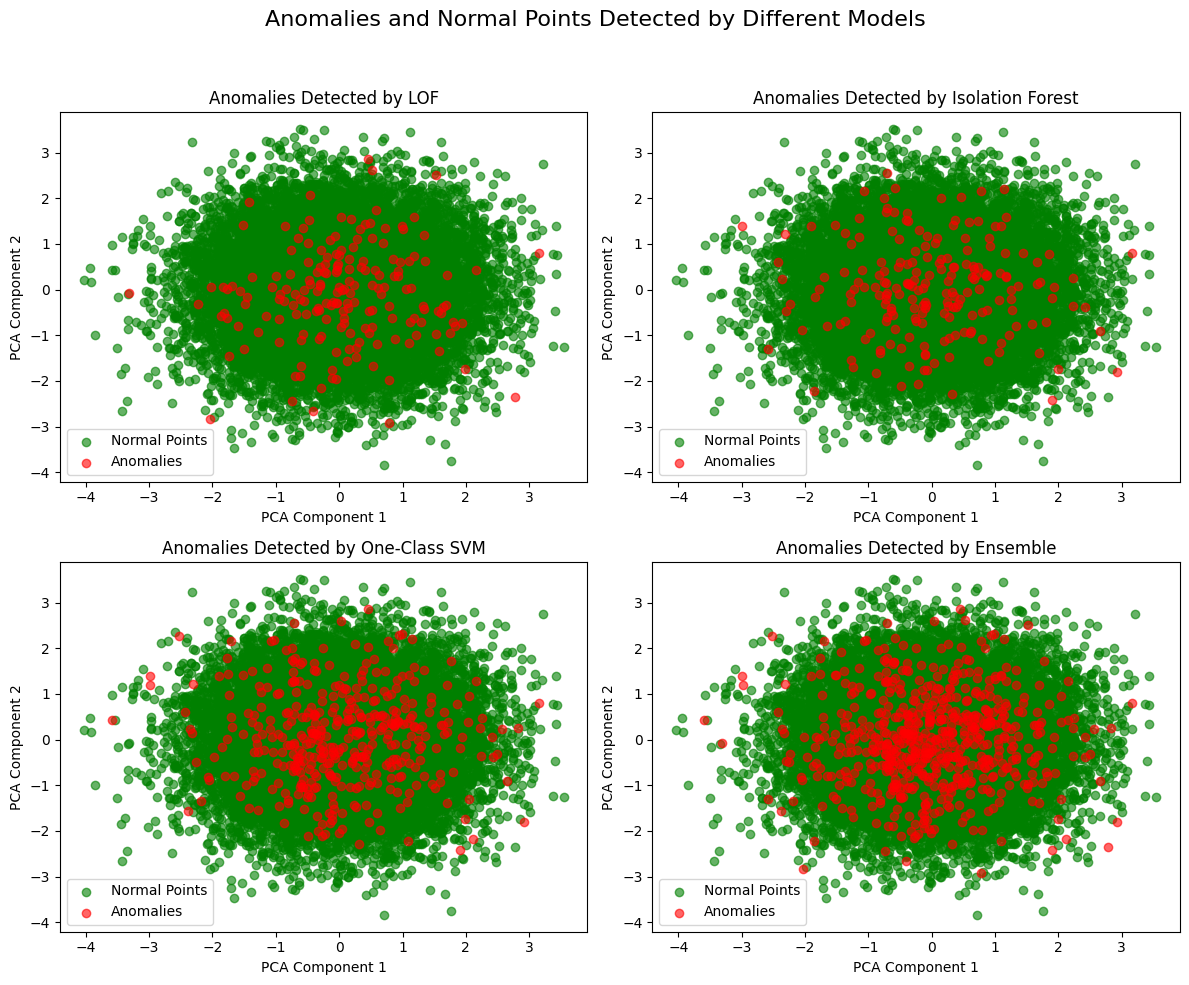

In [161]:
# Simulate input features for PCA
input_features = np.random.normal(0, 1, (len(ensemble_predictions), 10))
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(input_features)

# Add PCA-transformed components to the ensemble_predictions DataFrame
ensemble_predictions['PCA1'] = pca_transformed[:, 0]
ensemble_predictions['PCA2'] = pca_transformed[:, 1]

# Prepare figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Anomalies and Normal Points Detected by Different Models", fontsize=16)

# Helper function to plot anomalies and normal points
def plot_anomalies(ax, data, labels, title):
    ax.scatter(data['PCA1'][labels == 1], data['PCA2'][labels == 1], c='green', label='Normal Points', alpha=0.6)
    ax.scatter(data['PCA1'][labels == -1], data['PCA2'][labels == -1], c='red', label='Anomalies', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend()

# Plot each model's results
plot_anomalies(axes[0, 0], ensemble_predictions, ensemble_predictions['LOF_Anomaly'], "Anomalies Detected by LOF")
plot_anomalies(axes[0, 1], ensemble_predictions, ensemble_predictions['Anomaly'], "Anomalies Detected by Isolation Forest")
plot_anomalies(axes[1, 0], ensemble_predictions, ensemble_predictions['SVM_Anomaly'], "Anomalies Detected by One-Class SVM")
plot_anomalies(axes[1, 1], ensemble_predictions, ensemble_predictions['Final_Anomaly'], "Anomalies Detected by Ensemble")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Anomalies detected by LOF: 182
Anomalies detected by Isolation Forest: 199
Anomalies detected by One-Class SVM: 399
Anomalies detected by Ensemble: 598


<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Count of Anomalies Detected by Each Model')

Text(0.5, 0, 'Models')

Text(0, 0.5, 'Number of Anomalies')

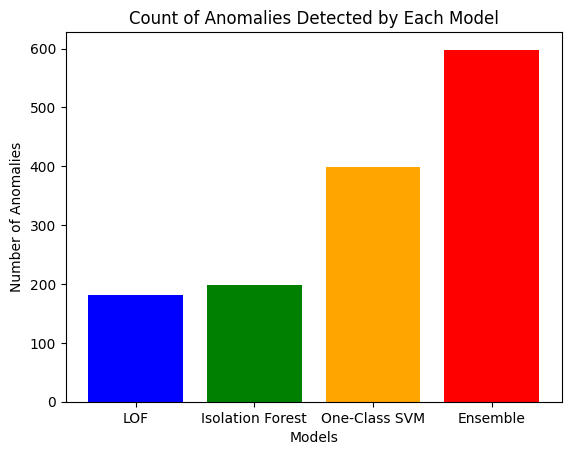

In [163]:
# Count anomalies (-1) in each model
lof_count = (ensemble_predictions['LOF_Anomaly'] == -1).sum()
if_count = (ensemble_predictions['Anomaly'] == -1).sum()
svm_count = (ensemble_predictions['SVM_Anomaly'] == -1).sum()
ensemble_count = (ensemble_predictions['Final_Anomaly'] == -1).sum()

# Display the counts
print(f"Anomalies detected by LOF: {lof_count}")
print(f"Anomalies detected by Isolation Forest: {if_count}")
print(f"Anomalies detected by One-Class SVM: {svm_count}")
print(f"Anomalies detected by Ensemble: {ensemble_count}")

import matplotlib.pyplot as plt

models = ['LOF', 'Isolation Forest', 'One-Class SVM', 'Ensemble']
counts = [lof_count, if_count, svm_count, ensemble_count]

plt.bar(models, counts, color=['blue', 'green', 'orange', 'red'])
plt.title('Count of Anomalies Detected by Each Model')
plt.xlabel('Models')
plt.ylabel('Number of Anomalies')
plt.show()